In [1]:
# Cell 1 — imports & config
from pathlib import Path
import json, time, math
from tqdm import tqdm
from pprint import pprint

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# USER CONFIG — edit if needed
ROOT = Path.cwd().parent            # set to project root if notebook is in notebooks/
EMB_ROOT = ROOT / "embeddings"      # embeddings/<split>/<video>.npy
SPATIAL_CKPT = ROOT / "checkpoints" / "spatial" / "spatial_best_valAUC.pth"
TEMPORAL_CKPT = ROOT / "checkpoints" / "temporal" / "temporal_best_valAUC.pth"
LABELS_JSON = ROOT / "data" / "labels.json"
OUT_DIR = ROOT / "ensemble"
OUT_DIR.mkdir(parents=True, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [2]:
# Cell 2 — load labels mapping
with open(LABELS_JSON, "r") as f:
    labels_map = json.load(f)
print("Labels entries:", len(labels_map))
# helper
def get_label_by_stem(stem):
    if stem in labels_map: return int(labels_map[stem])
    for k,v in labels_map.items():
        if stem in k: return int(v)
    raise KeyError(f"Label not found for {stem}")

Labels entries: 5283


In [3]:
# Cell 3 — define model classes (must match training code)
import timm
# SpatialModel must match architecture used in training (head shape)
class SpatialModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b3", pretrained=False, head_hidden=512, dropout=0.4):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features
        self.head = nn.Sequential(
            nn.Linear(feat_dim, head_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1)
        )
    def forward_from_feats(self, feats):
        # feats: [T, feat_dim] or [B, T, feat_dim]
        was_batched = (feats.ndim == 3)
        if not was_batched:
            feats = feats[None]   # [1, T, feat]
        B, T, F = feats.shape
        flat = feats.view(-1, F)
        logits = self.head(flat).view(B, T).squeeze(0 if B==1 else None)
        if not was_batched:
            logits = logits.squeeze(0)
        return logits  # per-frame logits (no sigmoid)

In [4]:
# Cell 4 — temporal model class (must match training code)
import torch.nn.utils.rnn as rnn_utils
class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.att = nn.Linear(hidden_dim, 1)
    def forward(self, h, lengths):
        B, T, H = h.shape
        lengths = torch.clamp(lengths, min=1)
        scores = self.att(h).squeeze(-1)  # [B, T]
        mask = torch.arange(T, device=h.device).unsqueeze(0) >= lengths.unsqueeze(1)
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=1)
        out = (h * weights.unsqueeze(-1)).sum(dim=1)
        return out, weights

class TemporalModel(nn.Module):
    def __init__(self, feat_dim, hidden=512, nlayers=2, bidir=True, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(feat_dim, hidden, nlayers, batch_first=True, bidirectional=bidir, dropout=dropout if nlayers>1 else 0)
        out_dim = hidden * (2 if bidir else 1)
        self.attn = AttentionPool(out_dim)
        self.head = nn.Sequential(nn.Linear(out_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256,1))
    def forward_from_feats(self, feats, lengths):
        # feats: [T, feat] or [B, T, feat]
        was_batched = (feats.ndim == 3)
        if not was_batched:
            feats = feats[None]   # [1, T, F]
            lengths = torch.tensor([lengths], dtype=torch.long)
        # sort + pack
        lengths_sorted, perm = lengths.sort(descending=True)
        feats_sorted = feats[perm]
        packed = rnn_utils.pack_padded_sequence(feats_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, _ = self.lstm(packed)
        out_unpacked, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        _, unperm = perm.sort()
        out = out_unpacked[unperm]
        lengths = lengths[unperm]
        pooled, att = self.attn(out, lengths)
        logits = self.head(pooled).squeeze(1)
        if not was_batched:
            logits = logits.squeeze(0)
        return logits  # video-level logits (no sigmoid)

In [5]:
# Cell 5 — load checkpoints (spatial head + temporal model)
# Load spatial model (we only need the head weights for features -> logits)
spatial = SpatialModel(pretrained=False).to("cpu")   # load on CPU first
spatial_ck = torch.load(SPATIAL_CKPT, map_location="cpu")
state = spacial_state = spacial_state = spacial_state = None
# handle saver format: ck may contain "model_state"
if "model_state" in spatial_ck:
    state = spatial_ck["model_state"]
else:
    state = spatial_ck
# try load strictly; if keys prefixed, strip module.
new_state = {}
for k,v in state.items():
    nk=k.replace("module.", "") if k.startswith("module.") else k
    new_state[nk]=v
spatial.load_state_dict(new_state, strict=False)
spatial.eval()
print("Loaded spatial checkpoint.")

# Load temporal model (full)
# instantiate TemporalModel with FEAT_DIM detected from embeddings later — just placeholder here
# We'll lazy-load by reading a sample embedding then creating temporal accordingly (below).
print("Spatial and Temporal checkpoint loading ready (temporal will be created after feat_dim discovery).")

Loaded spatial checkpoint.
Spatial and Temporal checkpoint loading ready (temporal will be created after feat_dim discovery).


In [6]:
# Cell 6 — discover feat_dim and create temporal model
# pick a sample embedding file to get feat dim
sample = next((EMB_ROOT/"train").glob("*.npy"), None)
if sample is None:
    sample = list((EMB_ROOT/"train").glob("*.npy"))[0]
arr = np.load(sample)
FEAT_DIM = arr.shape[1]
print("Feat dim discovered:", FEAT_DIM)

# create temporal model and load checkpoint
temporal = TemporalModel(feat_dim=FEAT_DIM, hidden=512, nlayers=2, bidir=True, dropout=0.3).to("cpu")
temp_ck = torch.load(TEMPORAL_CKPT, map_location="cpu")
tstate = temp_ck.get("model_state", temp_ck)
newt = {k.replace("module.", ""):v for k,v in tstate.items()}
temporal.load_state_dict(newt, strict=False)
temporal.eval()
print("Loaded temporal checkpoint.")
# move models to DEVICE when running inference for speed
spatial = spatial.to(DEVICE)
temporal = temporal.to(DEVICE)

Feat dim discovered: 1536
Loaded temporal checkpoint.


In [7]:
# Cell 7 — function to compute per-video features
import math
def compute_video_features(split, spatial_model, temporal_model, top_k_frames=None):
    """
    Returns DataFrame: columns = [stem, split, label, spatial_mean_prob, spatial_std_prob, spatial_max_prob, temporal_logit]
    """
    out = []
    folder = EMB_ROOT / split
    files = sorted([p for p in folder.glob("*.npy")])
    for p in tqdm(files, desc=f"features:{split}"):
        stem = p.stem
        try:
            arr = np.load(p)   # (T, feat)
            if arr.shape[0] == 0:
                continue
            feats = torch.from_numpy(arr.astype(np.float32)).to(DEVICE)  # [T, F]
            # spatial: per-frame logits via head (use head on feats)
            with torch.no_grad():
                # spatial.forward_from_feats expects feats either [T, F] or [1, T, F]
                frame_logits = spatial_model.forward_from_feats(feats)  # [T] or [1,T] -> squeeze
            frame_probs = torch.sigmoid(frame_logits).detach().cpu().numpy().ravel()
            # optionally restrict to top_k frames (not necessary)
            spatial_mean = float(frame_probs.mean())
            spatial_std = float(frame_probs.std())
            spatial_max = float(frame_probs.max())
            spatial_median = float(np.median(frame_probs))
            # temporal: video-level logit from embeddings
            with torch.no_grad():
                # temporal expects [T,F] and lengths scalar
                temp_logit = float(temporal_model.forward_from_feats(feats.unsqueeze(0), torch.tensor([feats.shape[0]]).to(DEVICE)).item())
            label = get_label_by_stem(stem)
            out.append({
                "stem": stem,
                "split": split,
                "label": label,
                "spatial_mean": spatial_mean,
                "spatial_std": spatial_std,
                "spatial_max": spatial_max,
                "spatial_median": spatial_median,
                "temporal_logit": temp_logit
            })
        except Exception as e:
            print("SKIP", p, "ERR", e)
    return pd.DataFrame(out)

In [8]:
# Cell 8 — compute features for train/val/test (this may take a few minutes)
dfs = []
for s in ["train", "val", "test"]:
    if (EMB_ROOT / s).exists():
        dfs.append(compute_video_features(s, spatial, temporal))
features_df = pd.concat(dfs, ignore_index=True)
features_df.to_csv(OUT_DIR / "ensemble_features.csv", index=False)
features_df.head()

features:test: 100%|██████████| 255/255 [00:00<00:00, 567.93it/s]


,stem,split,label,spatial_mean,spatial_std,spatial_max,spatial_median,temporal_logit
0,000,train,1,0.948205,0.088707,0.994730,9.796171e-01,6.997919
1,000_003,train,1,0.995534,0.005364,1.000000,9.985341e-01,10.571057
2,001,train,0,0.036469,0.095721,0.289718,3.408732e-07,-12.161186
3,003,train,0,0.000001,0.000003,0.000010,3.090559e-14,-12.892393
4,003_000,train,1,0.999729,0.000662,1.000000,9.999961e-01,11.199828


In [9]:
# Cell 9 — prepare X, y, splits
from sklearn.model_selection import train_test_split
# features used (simple set)
feat_cols = ["spatial_mean", "spatial_std", "spatial_max", "spatial_median", "temporal_logit"]
X = features_df[feat_cols].values
y = features_df["label"].values
splits = features_df["split"].values
# Build train/val/test masks
train_mask = splits == "train"
val_mask   = splits == "val"
test_mask  = splits == "test"

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val     = X[val_mask], y[val_mask]
X_test, y_test   = X[test_mask], y[test_mask]

print("Train/Val/Test sizes:", len(y_train), len(y_val), len(y_test))

Train/Val/Test sizes: 4066 761 255


In [10]:
# Cell 10 — train a calibrated logistic regression (Platt)
base = LogisticRegression(C=1.0, solver="liblinear", max_iter=200)
calib = CalibratedClassifierCV(base, cv="prefit", method="sigmoid")  # we will fit base then calibrate
# fit base on train, then CalibratedClassifierCV requires fitted estimator if cv="prefit"
base.fit(X_train, y_train)
calib = CalibratedClassifierCV(base, cv="prefit", method="sigmoid")
calib.fit(X_val, y_val)   # calibrate on validation (platt)
# Save models
joblib.dump(base, OUT_DIR / "ensemble_lr_base.joblib")
joblib.dump(calib, OUT_DIR / "ensemble_lr_calibrated.joblib")
print("Saved ensemble models")

Saved ensemble models


c:\Users\lkmah\AppData\Local\Programs\anaconda3\envs\aiml\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [11]:
# Cell 11 — evaluate
def eval_model(model, X, y, label="set"):
    probs = model.predict_proba(X)[:,1]
    auc_score = roc_auc_score(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    prec, rec, _ = precision_recall_curve(y, probs)
    pr_auc = auc(rec, prec)
    return {"auc":auc_score, "fpr":fpr, "tpr":tpr, "prec":prec, "rec":rec, "pr_auc":pr_auc, "probs":probs}

for name, mdl in [("base", base), ("calibrated", calib)]:
    print("Model:", name)
    tr = eval_model(mdl, X_train, y_train, "train")
    va = eval_model(mdl, X_val, y_val, "val")
    te = eval_model(mdl, X_test, y_test, "test")
    print(f" Train AUC: {tr['auc']:.4f}  Val AUC: {va['auc']:.4f}  Test AUC: {te['auc']:.4f}")

Model: base
 Train AUC: 1.0000  Val AUC: 0.9951  Test AUC: 0.9906
Model: calibrated
 Train AUC: 1.0000  Val AUC: 0.9951  Test AUC: 0.9906


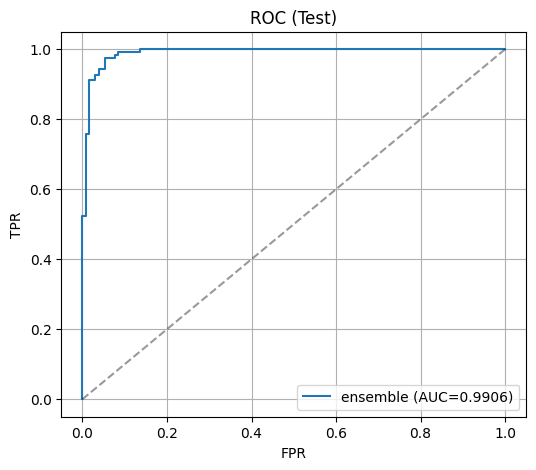

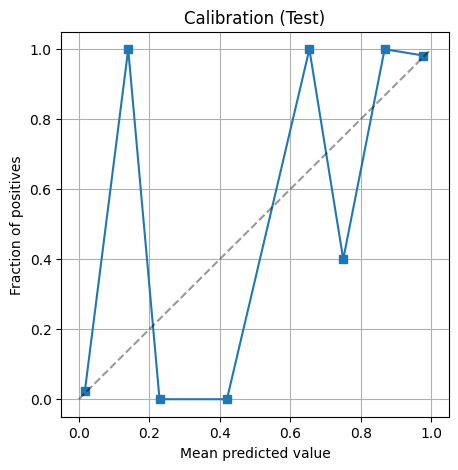

In [12]:
# Cell 12 — plot ROC (test) and calibration curve
plt.figure(figsize=(6,5))
te = eval_model(calib, X_test, y_test)
plt.plot(te["fpr"], te["tpr"], label=f"ensemble (AUC={te['auc']:.4f})")
plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Test)"); plt.legend()
plt.grid(True)
plt.savefig(OUT_DIR / "roc_test.png", dpi=150)
plt.show()

# calibration plot
prob_pos = te["probs"]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.figure(figsize=(5,5))
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("Mean predicted value"); plt.ylabel("Fraction of positives")
plt.title("Calibration (Test)")
plt.grid(True)
plt.savefig(OUT_DIR / "calibration_test.png", dpi=150)
plt.show()

In [13]:
# Cell 13 — save ensemble predictions (test)
test_df = features_df[features_df["split"]=="test"].copy()
test_df["ensemble_prob"] = te["probs"]
test_df.to_csv(OUT_DIR / "test_with_ensemble_probs.csv", index=False)
print("Saved test predictions.")

Saved test predictions.
